<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [SYNOP2] - Time series with RNN - Try a prediction
<!-- DESC --> Episode 2 : Training session and first predictions
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Make a simple prediction (3h)
 - Understanding the use of a recurrent neural network


SYNOP meteorological data, available at: https://public.opendatasoft.com

## What we're going to do :

 - Read our dataset
 - Select our data and normalize it
 - Doing our training
 - Making simple predictions

## Step 1 - Import and init
### 1.1 - Python

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import math, random
import matplotlib.pyplot as plt

import pandas as pd
import h5py, json
import os,time,sys

from importlib import reload

sys.path.append('..')
import fidle.pwk as ooo

place, datasets_dir = ooo.init()

def np_print(*args):
    with np.printoptions(formatter={'float':'{:8.2f}'.format}, linewidth=np.inf):
        for a in args:
            print(a)    


FIDLE 2020 - Practical Work Module
Version              : 0.57 DEV
Run time             : Thursday 10 September 2020, 17:06:53
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Current place        : Fidle at IDRIS
Dataset dir          : /gpfswork/rech/mlh/commun/datasets
Update keras cache   : Done


## Step 2 - Read and prepare dataset
### 2.1 - Read it

In [2]:
dataset_filename = 'synop-LYS.csv'
schema_filename  = 'synop.json'
train_len        = 25000
features         = ['tend', 'cod_tend', 'dd', 'ff', 'td', 'u', 'ww', 'pres', 'rafper', 'rr1', 'rr3', 'tc']
features_len     = len(features)

# ---- Read dataset

df = pd.read_csv(f'{datasets_dir}/SYNOP/{dataset_filename}', header=0, sep=';')

# ---- Train / Test

dataset_train = df.loc[ :train_len-1, features ]
dataset_test  = df.loc[train_len:,    features ]
ooo.subtitle('Train dataset example :')
display(dataset_train.head(15))

# ---- Normalize, and convert to numpy array

mean = dataset_train.mean()
std  = dataset_train.std()
dataset_train = (dataset_train - mean) / std
dataset_test  = (dataset_test  - mean) / std

ooo.subtitle('After normalization :')
display(dataset_train.describe().style.format("{0:.2f}"))

dataset_train = dataset_train.to_numpy()
dataset_test  = dataset_test.to_numpy()


print('Dataset : ',df.shape)
print('Train dataset : ',dataset_train.shape)
print('Test  dataset : ',dataset_test.shape)


<br>**Train dataset example :**

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
0,-120.0,6.0,0.0,0.0,278.75,88.0,60.0,96250.0,4.1,0.0,0.0,7.5
1,-150.0,6.0,60.0,1.0,278.65,93.0,61.0,96100.0,2.6,0.2,0.6,6.6
2,10.0,3.0,280.0,2.1,278.85,95.0,58.0,96110.0,2.6,0.0,0.4,6.4
3,230.0,3.0,310.0,2.6,279.15,96.0,50.0,96340.0,5.7,0.0,3.0,6.6
4,280.0,1.0,330.0,4.6,278.15,94.0,21.0,96620.0,8.7,0.4,0.8,5.9
5,480.0,3.0,350.0,5.1,276.95,91.0,60.0,97100.0,8.2,0.2,0.4,5.2
6,530.0,2.0,350.0,3.1,274.05,83.0,21.0,97630.0,7.2,0.0,0.0,3.5
7,450.0,2.0,340.0,6.2,272.15,81.0,2.0,98080.0,9.3,0.0,0.0,1.9
8,280.0,1.0,320.0,6.2,270.15,74.0,2.0,98360.0,10.3,0.0,0.0,1.1
9,220.0,1.0,290.0,2.6,269.65,72.0,2.0,98580.0,5.1,0.0,0.0,1.0


<br>**After normalization :**

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
count,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00
mean,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-6.80,-1.59,-1.75,-1.37,-5.18,-3.82,-0.52,-4.94,-1.64,-0.31,-0.27,-3.03
25%,-0.64,-0.85,-0.64,-0.76,-0.72,-0.71,-0.42,-0.55,-0.69,-0.15,-0.20,-0.75
50%,-0.00,-0.48,-0.12,-0.19,0.05,0.18,-0.42,0.03,-0.27,-0.15,-0.20,-0.01
75%,0.63,0.99,1.08,0.50,0.79,0.84,-0.37,0.61,0.52,-0.15,-0.20,0.72
max,7.16,1.36,1.34,6.28,2.40,1.62,4.46,3.10,6.29,30.36,31.27,3.02


Dataset :  (29165, 14)
Train dataset :  (25000, 12)
Test  dataset :  (4165, 12)


### 2.2 - Prepare data generator

In [3]:
sequence_len = 16
batch_size   = 32

# ---- Train generator
train_generator = TimeseriesGenerator(dataset_train, dataset_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(dataset_test,  dataset_test,  length=sequence_len,  batch_size=batch_size)

# ---- About

x,y=train_generator[0]
print(f'Nombre de train batchs disponibles : ', len(train_generator))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

# x,y=train_generator[0]
# np_print(x[0])
# np_print(y[0])

Nombre de train batchs disponibles :  781
batch x shape :  (32, 16, 12)
batch y shape :  (32, 12)


## Step 3 - Create a model

In [4]:
model = keras.models.Sequential()
model.add( keras.layers.InputLayer(input_shape=(sequence_len, features_len)) )
model.add( keras.layers.LSTM(100, activation='relu') )
model.add( keras.layers.Dropout(0.2) )
model.add( keras.layers.Dense(features_len) )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               45200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 12)                1212      
Total params: 46,412
Trainable params: 46,412
Non-trainable params: 0
_________________________________________________________________


# Step 4 - Compile and run

### 4.1 - Callback

In [5]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 4.2 - Compile

In [6]:
model.compile(optimizer='adam', 
              loss='mse', 
              metrics   = ['mae'] )

### 4.3 - Fit

In [7]:
%%time

history=model.fit_generator(train_generator, 
                            epochs=10, 
                            verbose=1,
                            validation_data = test_generator,
                            callbacks = [bestmodel_callback])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
781/781 [==============================] - 14s 17ms/step - loss: 0.6023 - mae: 0.5071 - val_loss: 0.4669 - val_mae: 0.4289
Epoch 2/10
781/781 [==============================] - 13s 17ms/step - loss: 0.5045 - mae: 0.4379 - val_loss: 0.4392 - val_mae: 0.4006
Epoch 3/10
781/781 [==============================] - 13s 17ms/step - loss: 0.4809 - mae: 0.4192 - val_loss: 0.4367 - val_mae: 0.4023
Epoch 4/10
781/781 [==============================] - 13s 16ms/step - loss: 0.4703 - mae: 0.4090 - val_loss: 0.4305 - val_mae: 0.4091
Epoch 5/10
781/781 [==============================] - 13s 17ms/step - loss: 0.4574 - mae: 0.4019 - val_loss: 0.4155 - val_mae: 0.3849
Epoch 6/10
781/781 [==============================] - 13s 17ms/step - loss: 0.4503 - mae: 0.3954 - val_loss: 0.4062 - val_mae: 0.3730
Epoch 7/10
781/781 [==============================] - 13s 17ms/step - loss: 0.4440 - mae: 0.3916 - val_loss: 0.4108 - va

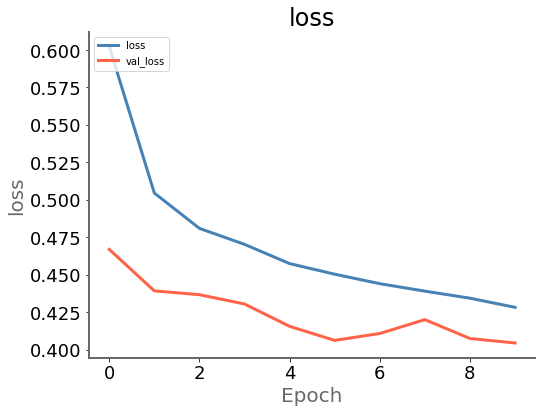

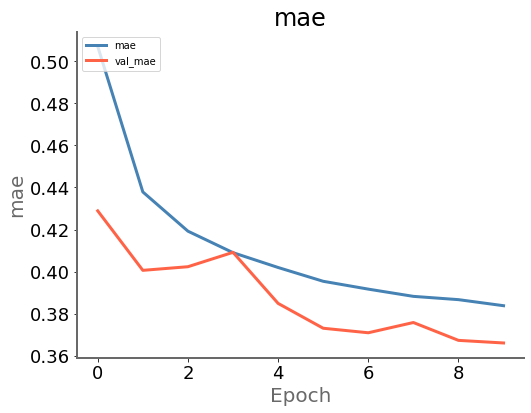

In [8]:
ooo.plot_history(history,plot={'loss':['loss','val_loss'], 'mae':['mae','val_mae']})

## Step 5 - Predict

### 5.1 - Load model

In [9]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')

### 5.2 Make a prediction

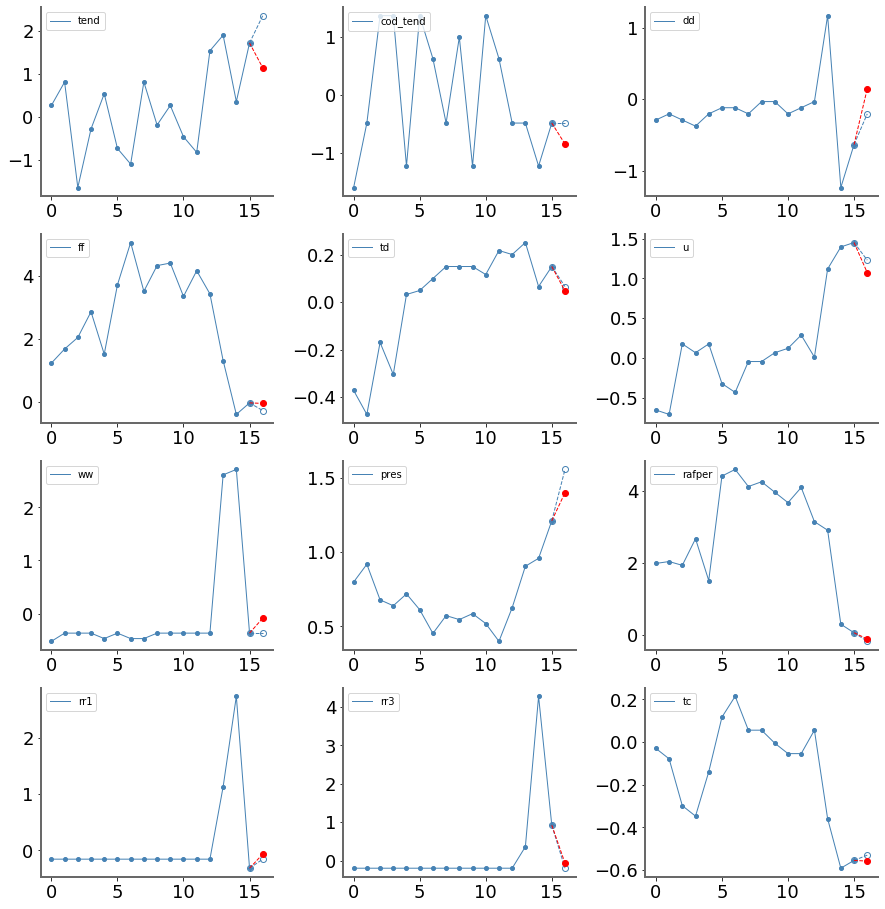

In [10]:
s=random.randint(0,len(dataset_test)-sequence_len)

sequence      = dataset_test[s:s+sequence_len]
sequence_true = dataset_test[s:s+sequence_len+1]

pred = loaded_model.predict( np.array([sequence]) )

# ---- Show result
reload(ooo)
ooo.plot_multivariate_serie(sequence_true, predictions=pred, labels=features)


### 5.3 Full prediction

Gap between prediction and reality : 0.07 °C


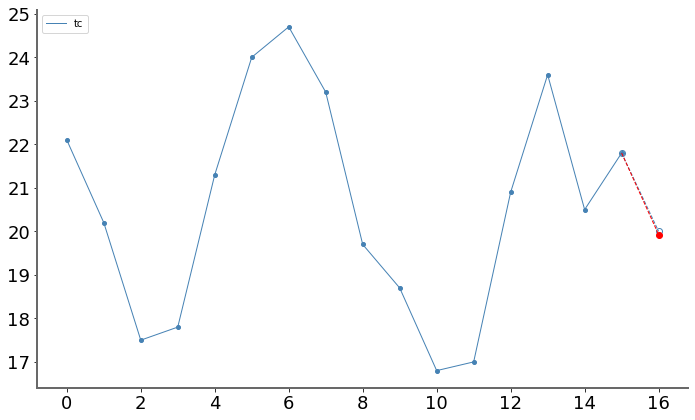

In [17]:
def denormalize(mean,std,seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq


# ---- Get a sequence

i=random.randint(0,len(dataset_test)-sequence_len)
sequence      = dataset_test[i:i+sequence_len]
sequence_true = dataset_test[i:i+sequence_len+1]

# ---- Prediction

pred = loaded_model.predict( np.array([sequence]) )

# ---- De-normalization

sequence_true = denormalize(mean,std, sequence_true)
pred          = denormalize(mean,std, pred)

# ---- Show it
feat=11

delta_deg=abs(sequence_true[-1][feat]-pred[-1][feat])
print(f'Gap between prediction and reality : {delta_deg:.2f} °C')

reload(ooo)
ooo.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, only_features=[feat],width=14, height=8)


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>